<a href="https://colab.research.google.com/github/kamnsv/deep-learning-course-practice-2025/blob/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%961_%D0%9A%D0%B0%D0%BC%D0%BD%D0%B5%D0%B2_%D0%A1.%D0%92._3824%D0%9C1%D1%81%D0%A4%D0%981/laboratory_work_1/KamnevSV/01_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

## Окружение

In [16]:
#@title Подключение библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torchvision import datasets

In [6]:
#@title Параметры
np.random.seed(42)
input_dim = 28 * 28
hidden_dim = 300
output_dim = 10
learning_rate = 0.1
batch_size = 32
epochs = 20

## Датасет

In [3]:
#@title Загрузка датасета MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 136MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 41.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 50.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.25MB/s]


In [4]:
#@title Преобразование в numpy
x_train = np.array([np.array(img) for img, _ in train_dataset])
y_train = np.array([label for _, label in train_dataset])

# Преобразование test к numpy
x_test = np.array([np.array(img) for img, _ in test_dataset])
y_test = np.array([label for _, label in test_dataset])

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

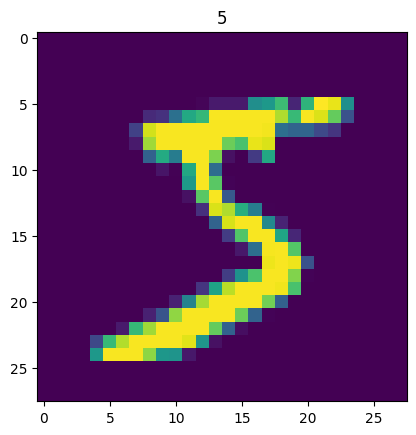

In [9]:
#@title Обзор
plt.imshow(x_train[0])
plt.title(y_train[0])
pass

In [11]:
#@title Препроцессинг

# Нормализация
x_train = x_train.astype(float) / 255.0
x_test = x_test.astype(float) / 255.0

# Изменение размера
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Кодирование в ohe
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000,))

In [13]:
#@title Генератор батчей
def batches(x_data, y_data, batch_size):
    idxs = np.arange(len(x_data))
    np.random.shuffle(idxs)
    for start in range(0, len(x_data), batch_size):
        end = start + batch_size
        batch_idxs = idxs[start:end]
        yield x_data[batch_idxs], y_data[batch_idxs]

## Нейросеть на numpy

In [19]:
#@title Glorot (Xavier) инициализация весов модели
W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(1 / input_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(1 / hidden_dim)
b2 = np.zeros((1, output_dim))

In [20]:
#@title Softmax
def softmax(x):
  exps = np.exp(x)
  return exps / exps.sum(axis=1, keepdims=True)

In [21]:
#@title Cross entropy
def cross_entropy(y_true, y_pred):
    """
    ℒ(θ) = -1/N ∑_{i=1}^{N} ∑_{k=1}^{K} y_{i,k} log(p_{i,k})
    y_true, y_pred: shape (N, K)
    """
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / N


In [22]:
#@title Обучение
losses = []
for epoch in range(epochs):
    for x_batch, y_batch in batches(x_train, y_train, batch_size):
        # Forward
        z1 = np.dot(x_batch, W1) + b1
        a1 = np.maximum(0, z1) # relu
        z = np.dot(a1, W2) + b2
        out = softmax(z)

        # Backward
        dz = (out - y_batch) / len(x_batch) # dℒ/dz = softmax - y
        dW2 = np.dot(a1.T, dz)
        db2 = np.sum(dz, axis=0, keepdims=True)
        da1 = np.dot(dz, W2.T)
        dz1 = da1 * (z1 > 0)  # dx_relu
        dW1 = np.dot(x_batch.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Обновление весов
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    # Loss
    losses.append(cross_entropy(y_batch, out))
    print(f'Epoch {epoch+1}/{epochs}, loss={losses[-1]:.8f}')

Epoch 1/20, loss=0.13207557
Epoch 2/20, loss=0.05660968
Epoch 3/20, loss=0.01462541
Epoch 4/20, loss=0.09474886
Epoch 5/20, loss=0.11650423
Epoch 6/20, loss=0.00780732
Epoch 7/20, loss=0.02081750
Epoch 8/20, loss=0.03514114
Epoch 9/20, loss=0.01453622
Epoch 10/20, loss=0.05720729
Epoch 11/20, loss=0.03174210
Epoch 12/20, loss=0.00089926
Epoch 13/20, loss=0.00201545
Epoch 14/20, loss=0.01413177
Epoch 15/20, loss=0.03030467
Epoch 16/20, loss=0.00229139
Epoch 17/20, loss=0.00975616
Epoch 18/20, loss=0.00467144
Epoch 19/20, loss=0.00317727
Epoch 20/20, loss=0.00336480


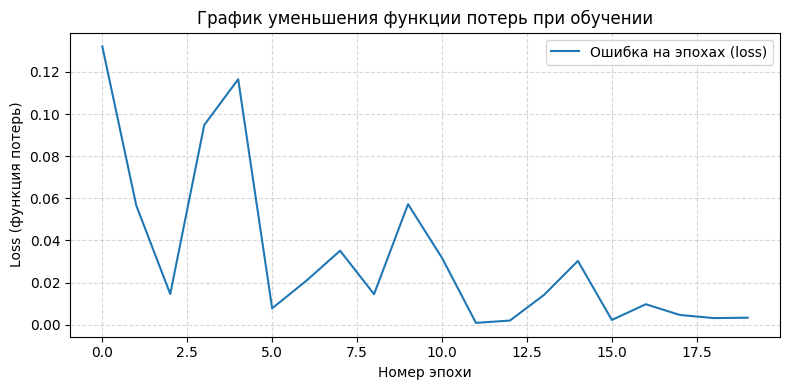

In [23]:
#@title График ошибки
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Ошибка на эпохах (loss)')

plt.title('График уменьшения функции потерь при обучении')
plt.xlabel('Номер эпохи')
plt.ylabel('Loss (функция потерь)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

pass

In [24]:
#@title Предикт
def predict(x):
  z1 = np.dot(x, W1) + b1
  a1 = np.maximum(0, z1) # relu
  z = np.dot(a1, W2) + b2
  out = softmax(z)
  return np.argmax(out, axis=1)

In [25]:
#@title Проверка точности на тесте
y_pred = predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

